# Introduction
This is my first competition and I decided to join Kaggle's Spaceship Titanic Competition. We are given training data which contains information about passengers and whether they were transported to an alternate dimension or not. Using this, we must predict whether the passengers given in the testing data were transported or not.

Start by importing libraries and setting default options

In [1]:
import warnings

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

#Display all columns
pd.options.display.max_columns = None

# Mute warnings
warnings.filterwarnings('ignore')

Below is an initial look at the training data

In [2]:
df_train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv", index_col="PassengerId")
df_test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv", index_col="PassengerId")
df_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Initial Data Analysis ##
All columns but the target contain missing values. About 2% of data is missing

In [3]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [4]:
#Number of missing values in each column
df_train.isna().sum()

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [5]:
df_train.dtypes

HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

### Categorical Data ####

Analyzing the categorical columns below, CryoSleep, VIP, and Transported seem to be boolean values. Cabin and Name are features that are more unique among passengers.

There don't seem to be any typos or errors that need to be cleaned

In [6]:
for col in df_train.columns:
    if df_train[col].dtype in ["object", "bool"]:
        print(f"{df_train[col].value_counts()}")
        print(f"Missing: {df_train[col].isna().sum()}\n")

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64
Missing: 201

CryoSleep
False    5439
True     3037
Name: count, dtype: int64
Missing: 217

Cabin
G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: count, Length: 6560, dtype: int64
Missing: 199

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64
Missing: 182

VIP
False    8291
True      199
Name: count, dtype: int64
Missing: 203

Name
Gollux Reedall        2
Elaney Webstephrey    2
Grake Porki           2
Sus Coolez            2
Apix Wala             2
                     ..
Jamela Griffy         1
Hardy Griffy          1
Salley Mckinn         1
Mall Frasp            1
Propsh Hontichre      1
Name: count, Length: 8473, dtype: int64
Missing: 200

Transported
True     4378
False    4315
Name: count, dtype: int64
Missing: 0



### Numerical Data ###
Below are kernel density estimate plots that show the distribution for every numerical feature. All features but `Age` show extreme right skew. These skewed features represent how much each passenger spent on certain amenities. The skew seems to result form the fact that a large majority of passengers didn't spend much money or any at all.

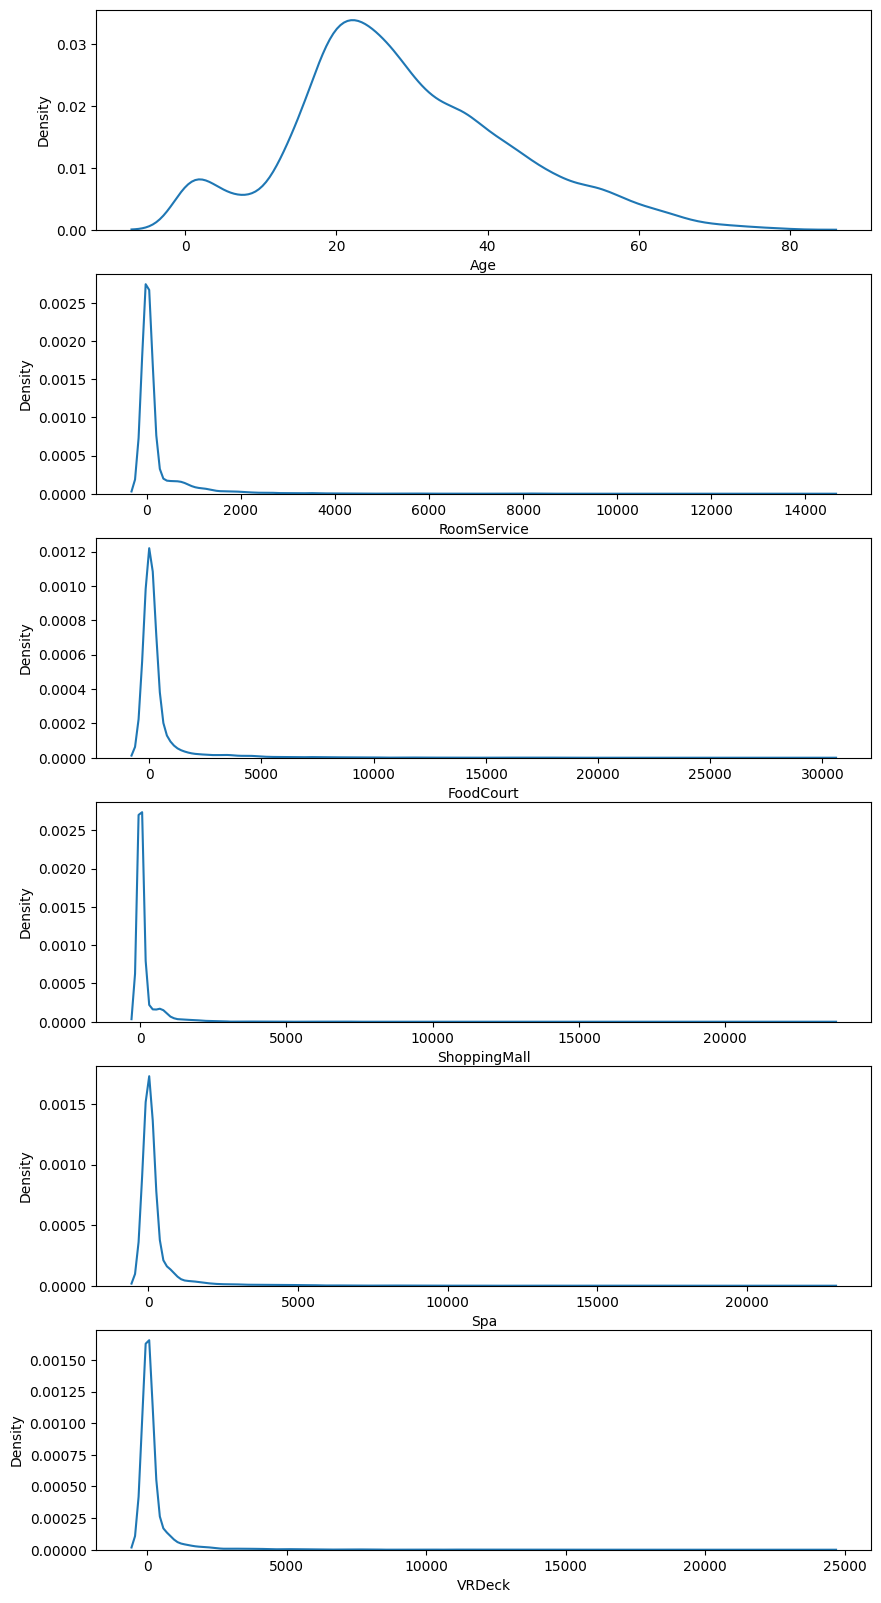

In [7]:
fig, ax = plt.subplots(6, 1, figsize=(10, 20))

#Numerical columns
numerical_cols = [col for col in df_train if df_train[col].dtype == "float64"]

for i in range(6):
    col = numerical_cols[i]
    sns.kdeplot(df_train[col], ax=ax[i])

## Preprocessing Data ##
This function loads fresh dataframes whenever needed. It splits the data encoding and imputation into their own seperate functions which will be defined below after taking a closer look at the data.

In [8]:
def load_data():
    df_train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv", index_col="PassengerId")
    df_test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv", index_col="PassengerId")
    
    #Encode and impute training and testing data together
    df = pd.concat([df_train, df_test])
    df = encode(df)
    df = impute(df)
    
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test

### Encoding Data Type ###
The categorical data will be encoded to be of `categorical` type so data processing will be easier. The boolean data will be encoded to be of `int` type.

In [9]:
#The only categories that seem to be ordinal are Transported, VIP and CryoSleep. The rest seem to be nominal
nom_features = ["HomePlanet", "Cabin", "Destination", "Name"]
bool_features = ["VIP", "CryoSleep"]

def encode(df):
    for col in nom_features:
        df[col] = df[col].astype("category")   
        
    #Add "None" to categories for later
    df["Cabin"] = df["Cabin"].cat.add_categories("None")
    df["Name"] = df["Name"].cat.add_categories("None")
    
    #Target will be encoded as categorical to use XGBClassifier later
    df["Transported"] = df["Transported"].astype("category")
    
    return df

### Imputing Data ###
Besides the `Age` feature, all the numerical features show very heavy skew. Therefore those columns will be imputed with the median since this method is more robust.

For the categorical features, they will be imputed with the most common value. This makes less sense for the `Cabin` and `Name` features. For these features, `NaN` will be imputed with `"None"`.

Finally, the function will create indicator columns that indicate whether data was originally missing.

In [10]:
def impute(df):
    #Create indicator columns for missing values
    df_missing = pd.DataFrame()
    for name in df:
        if df[name].isna().any() and name != "Transported":     
            df_missing[name + "_missing"] = df[name].isna().astype(int)
            
    #Impute missing values with False since False is the most common value for all boolean features
    df_bool = df[bool_features]
    df_bool = df_bool.fillna(False)
    df_bool = df_bool.astype("int")
    
    num_imputer = SimpleImputer(strategy="median")
    cat_imputer = SimpleImputer(strategy="most_frequent")
    
    #Seperate df to impute columns differently. Convert the imputed matrices back into dataframes
    df_num = df[numerical_cols]
    df_num = pd.DataFrame(num_imputer.fit_transform(df_num), columns=numerical_cols, index=df_num.index)
    
    cat_cols = ["HomePlanet", "Destination"]
    df_cat = df[cat_cols]
    df_cat = pd.DataFrame(cat_imputer.fit_transform(df_cat), columns=cat_cols, index=df_cat.index).astype("category")
    
    df_special = df[["Cabin", "Name"]]
    df_special = df_special.fillna("None")
    
    return pd.concat([df_num, df_bool, df_cat, df_special, df_missing, df["Transported"]], axis=1)

## Load Data ##
Now, the function can be called to create the preprocessed dataframes.

In [11]:
df_train, df_test = load_data()

Here's a look at the newly processed training data

In [12]:
df_train

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,VIP,CryoSleep,HomePlanet,Destination,Cabin,Name,HomePlanet_missing,CryoSleep_missing,Cabin_missing,Destination_missing,Age_missing,VIP_missing,RoomService_missing,FoodCourt_missing,ShoppingMall_missing,Spa_missing,VRDeck_missing,Name_missing,Transported
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,
0001_01,39.0,0.0,0.0,0.0,0.0,0.0,0,0,Europa,TRAPPIST-1e,B/0/P,Maham Ofracculy,0,0,0,0,0,0,0,0,0,0,0,0,False
0002_01,24.0,109.0,9.0,25.0,549.0,44.0,0,0,Earth,TRAPPIST-1e,F/0/S,Juanna Vines,0,0,0,0,0,0,0,0,0,0,0,0,True
0003_01,58.0,43.0,3576.0,0.0,6715.0,49.0,1,0,Europa,TRAPPIST-1e,A/0/S,Altark Susent,0,0,0,0,0,0,0,0,0,0,0,0,False
0003_02,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0,Europa,TRAPPIST-1e,A/0/S,Solam Susent,0,0,0,0,0,0,0,0,0,0,0,0,False
0004_01,16.0,303.0,70.0,151.0,565.0,2.0,0,0,Earth,TRAPPIST-1e,F/1/S,Willy Santantines,0,0,0,0,0,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,41.0,0.0,6819.0,0.0,1643.0,74.0,1,0,Europa,55 Cancri e,A/98/P,Gravior Noxnuther,0,0,0,0,0,0,0,0,0,0,0,0,False
9278_01,18.0,0.0,0.0,0.0,0.0,0.0,0,1,Earth,PSO J318.5-22,G/1499/S,Kurta Mondalley,0,0,0,0,0,0,0,0,0,0,0,0,False
9279_01,26.0,0.0,0.0,1872.0,1.0,0.0,0,0,Earth,TRAPPIST-1e,G/1500/S,Fayey Connon,0,0,0,0,0,0,0,0,0,0,0,0,True


## Establish Baseline ##
Below is a function that will create a score with features. This will let us establish our baseline score and also judge whether newly created features are effective. It uses 5-fold cross validation and scores using accuracy.

In [13]:
def score(X, y, model=XGBClassifier()):
    
    #Label encode categorical features
    for col in X.select_dtypes(["category"]):
        X[col], _ = X[col].factorize()

        
    score = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    score = score.mean()
    return score

In [14]:
X = df_train.copy()
y = X.pop("Transported")

score(X, y)

0.644076890346753

# Make Mutual Information Scores #
Now, a function to create and plot mutual information scores will be made. This will help identify the features with the most potential for feature engineering. It will also help determine if newly created features are useful.

In [15]:
#Returns series with mi scores of each feature
def get_MI_scores(X, y):
    
    #Label encode categorical features
    for col in X.select_dtypes(["category"]):
        X[col], _ = X[col].factorize()

    mi_scores = mutual_info_regression(X, y, random_state=0)
    mi_scores = pd.Series(mi_scores, index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [16]:
X = df_train.copy()
y = X.pop("Transported")

mi_scores = get_MI_scores(X, y)
mi_scores

CryoSleep               0.115308
Spa                     0.079452
VRDeck                  0.056488
RoomService             0.051967
FoodCourt               0.047509
ShoppingMall            0.034860
HomePlanet              0.023622
Age                     0.019011
Cabin                   0.018378
Name                    0.013071
VIP                     0.011158
VRDeck_missing          0.004505
Cabin_missing           0.001639
RoomService_missing     0.000000
Spa_missing             0.000000
ShoppingMall_missing    0.000000
FoodCourt_missing       0.000000
HomePlanet_missing      0.000000
VIP_missing             0.000000
Age_missing             0.000000
Destination_missing     0.000000
CryoSleep_missing       0.000000
Destination             0.000000
Name_missing            0.000000
dtype: float64

`CryoSleep` and the spending features seem to be the most informative features. On the other hand, many features, especially the indicator features seem to be uninformative. This isn't a concrete ranking however, since their may be some interactions between features that might prove useful. For now, the uninformative features will be dropped to prevent overfitting.

In [17]:
#Drop all columns with mi_score = 0
uninformative = mi_scores > 0
#Keep Target column
uninformative["Transported"] = True

df_train = df_train.loc[:, uninformative]
df_test = df_test.loc[:, uninformative]

Our scoring function rates our model a little worse now but that's fine. Overfitting may only show its effects in the testing set.

In [18]:
X = df_train.copy()
y = X.pop("Transported")

score(X, y)

0.6237181137261933

# Feature Engineering #
Here's a look at our training data so far again:

In [19]:
df_train.head(15)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,VIP,CryoSleep,HomePlanet,Cabin,Name,Cabin_missing,VRDeck_missing,Transported
PassengerId,,,,,,,,,,,,,,
0001_01,39.0,0.0,0.0,0.0,0.0,0.0,0,0,Europa,B/0/P,Maham Ofracculy,0,0,False
0002_01,24.0,109.0,9.0,25.0,549.0,44.0,0,0,Earth,F/0/S,Juanna Vines,0,0,True
0003_01,58.0,43.0,3576.0,0.0,6715.0,49.0,1,0,Europa,A/0/S,Altark Susent,0,0,False
0003_02,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0,Europa,A/0/S,Solam Susent,0,0,False
0004_01,16.0,303.0,70.0,151.0,565.0,2.0,0,0,Earth,F/1/S,Willy Santantines,0,0,True
0005_01,44.0,0.0,483.0,0.0,291.0,0.0,0,0,Earth,F/0/P,Sandie Hinetthews,0,0,True
0006_01,26.0,42.0,1539.0,3.0,0.0,0.0,0,0,Earth,F/2/S,Billex Jacostaffey,0,0,True
0006_02,28.0,0.0,0.0,0.0,0.0,0.0,0,1,Earth,G/0/S,Candra Jacostaffey,0,1,True
0007_01,35.0,0.0,785.0,17.0,216.0,0.0,0,0,Earth,F/3/S,Andona Beston,0,0,True


Based off of our data, some features look like they could have more infromation extracted from them. Here are the ideas that I was able to spot:

* The spending features can be totaled to create a `TotalSpending` feature
* `Cabin` can be split into three more features. Taken from the competition description: "Takes the form `deck/num/side`, where `side` can be either `P` for Port or `S` for Starboard."
* `PassengerID` has two parts seperated by an underscore. Taken from the competition description: "Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and `pp` is their number within the group." From this, we can create a feature that represents how many people a passenger is traveling with.


## Spending Features ##
A `TotalSpending` feature will be created by adding all spending features together.

In [20]:
spending_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

df_train["TotalSpending"] = sum([df_train[col] for col in spending_cols])
df_test["TotalSpending"] = sum([df_test[col] for col in spending_cols])

df_train

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,VIP,CryoSleep,HomePlanet,Cabin,Name,Cabin_missing,VRDeck_missing,Transported,TotalSpending
PassengerId,,,,,,,,,,,,,,,
0001_01,39.0,0.0,0.0,0.0,0.0,0.0,0,0,Europa,B/0/P,Maham Ofracculy,0,0,False,0.0
0002_01,24.0,109.0,9.0,25.0,549.0,44.0,0,0,Earth,F/0/S,Juanna Vines,0,0,True,736.0
0003_01,58.0,43.0,3576.0,0.0,6715.0,49.0,1,0,Europa,A/0/S,Altark Susent,0,0,False,10383.0
0003_02,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0,Europa,A/0/S,Solam Susent,0,0,False,5176.0
0004_01,16.0,303.0,70.0,151.0,565.0,2.0,0,0,Earth,F/1/S,Willy Santantines,0,0,True,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,41.0,0.0,6819.0,0.0,1643.0,74.0,1,0,Europa,A/98/P,Gravior Noxnuther,0,0,False,8536.0
9278_01,18.0,0.0,0.0,0.0,0.0,0.0,0,1,Earth,G/1499/S,Kurta Mondalley,0,0,False,0.0
9279_01,26.0,0.0,0.0,1872.0,1.0,0.0,0,0,Earth,G/1500/S,Fayey Connon,0,0,True,1873.0


## Cabin Feature ##

`Cabin` is split into three new features: `Deck`, `Num`, `Side`. `Cabin` is also dropped since the 3 columns will probably represent a passenger's cabin better. `Cabin`'s cardinality is too high and is would behave similarly to `PassengerID`

In [21]:
#Replace "None" values so they can be split
df_train["Cabin"].replace("None", "None/None/None", inplace=True)
df_test["Cabin"].replace("None", "None/None/None", inplace=True)

#expand=True expands into different columns
df_train[["Deck", "Num", "Side"]] = df_train["Cabin"].str.split("/", expand=True).astype("category")
df_test[["Deck", "Num", "Side"]] = df_test["Cabin"].str.split("/", expand=True).astype("category")

#Drop Cabin feature
df_train.drop("Cabin", axis=1, inplace=True)
df_test.drop("Cabin", axis=1, inplace=True)

## Group Size ##

`PassengerId` will be used to create a `GroupSize` feature which indicates the size of a passenger's gorup. To recap, a passenger's ID is represented as `gggg_pp` where the number of passengers with the same `gggg` represents the size of that party.

In [22]:
#Create a function so that steps can be repeated on testing and training set
def create_groupSize(df):
    
    groupSize_df = df.reset_index()
    groupSize_df = groupSize_df[["PassengerId"]]
    #Split PassengerID to get first 4 digits
    groupSize_df[["Group", "Number"]] = groupSize_df["PassengerId"].str.split("_", expand=True)
    #Groups entries by Group number and returns a count of each group
    groupSize_df['GroupSize'] = groupSize_df.groupby('Group')['Group'].transform('count')
    
    #Set index again and append GroupSize back to df
    groupSize_df.set_index(groupSize_df["PassengerId"], inplace=True)
    df["GroupSize"] = groupSize_df["GroupSize"]
    return df

create_groupSize(df_train)
create_groupSize(df_test)

df_train.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,VIP,CryoSleep,HomePlanet,Name,Cabin_missing,VRDeck_missing,Transported,TotalSpending,Deck,Num,Side,GroupSize
PassengerId,,,,,,,,,,,,,,,,,,
0001_01,39.0,0.0,0.0,0.0,0.0,0.0,0,0,Europa,Maham Ofracculy,0,0,False,0.0,B,0,P,1
0002_01,24.0,109.0,9.0,25.0,549.0,44.0,0,0,Earth,Juanna Vines,0,0,True,736.0,F,0,S,1
0003_01,58.0,43.0,3576.0,0.0,6715.0,49.0,1,0,Europa,Altark Susent,0,0,False,10383.0,A,0,S,2
0003_02,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0,Europa,Solam Susent,0,0,False,5176.0,A,0,S,2
0004_01,16.0,303.0,70.0,151.0,565.0,2.0,0,0,Earth,Willy Santantines,0,0,True,1091.0,F,1,S,1


<Axes: xlabel='CryoSleep', ylabel='TotalSpending'>

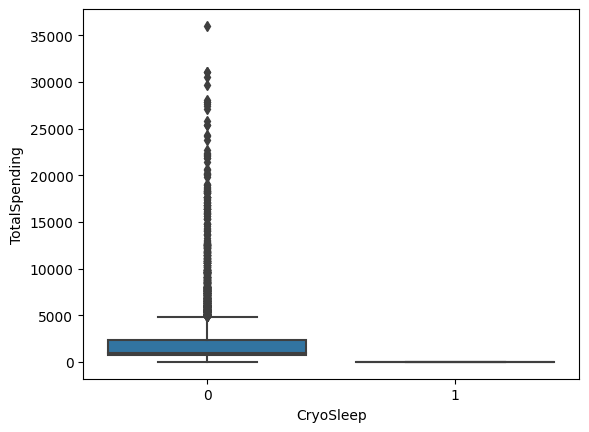

In [23]:
sns.boxplot(df_train, x="CryoSleep", y="TotalSpending")

## Reevaluation ##

This section will reevaluate the data's performance and mutual information scores.

In [24]:
X = df_train.copy()
y = X.pop("Transported")

score(X, y)

0.7110260053163365

The dataset's evaluation score is much higher now with the new features!

In [25]:
mi_scores = get_MI_scores(X, y)
mi_scores

TotalSpending     0.128563
CryoSleep         0.111293
RoomService       0.076851
Spa               0.074076
VRDeck            0.053224
ShoppingMall      0.049837
FoodCourt         0.045893
Deck              0.035059
HomePlanet        0.020582
Num               0.016492
Name              0.014399
VIP               0.008768
GroupSize         0.008224
Cabin_missing     0.007427
VRDeck_missing    0.000000
Side              0.000000
Age               0.000000
dtype: float64

Based off of our new mutual information scores, `TotalSpending` seems to be the most important feature that we've created. The features derived from `Cabin` and `PassengerId` don't seeem to have been as informative.

# Train Model and Make Submission #

Using Optuna and the `score()` function from earlier, 5 trials are run to find the best hyperparameters for an `XGBClassifier`.

In [26]:
def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        max_leaves=trial.suggest_int("max_leaves", 10, 50),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    model = XGBClassifier(**xgb_params)
    return score(X_train, y_train, model)

X_train = df_train.copy()
y_train = X_train.pop("Transported")

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

xgb_params = study.best_params

model = XGBClassifier(**xgb_params)
score(X_train, y_train, model)

[I 2024-08-03 22:55:57,521] A new study created in memory with name: no-name-5f7099c7-5577-46d3-a2f8-05854ca3ea12
[I 2024-08-03 22:56:28,139] Trial 0 finished with value: 0.7234476647888983 and parameters: {'max_depth': 5, 'max_leaves': 12, 'learning_rate': 0.0025523117266797327, 'n_estimators': 6162, 'min_child_weight': 2, 'colsample_bytree': 0.3259402386844224, 'subsample': 0.892835211971714, 'reg_alpha': 0.16860995375301846, 'reg_lambda': 0.0024166139619207294}. Best is trial 0 with value: 0.7234476647888983.
[I 2024-08-03 22:56:36,771] Trial 1 finished with value: 0.7877646174441219 and parameters: {'max_depth': 7, 'max_leaves': 16, 'learning_rate': 0.0022024205185666936, 'n_estimators': 1273, 'min_child_weight': 2, 'colsample_bytree': 0.6590618204521543, 'subsample': 0.8325857058232635, 'reg_alpha': 0.00010941037189871112, 'reg_lambda': 28.23234474292035}. Best is trial 1 with value: 0.7877646174441219.
[I 2024-08-03 22:57:01,339] Trial 2 finished with value: 0.7487645175229339 an

0.7906387743177401

Here is the best trial run so far: Trial 15 finished with value: 0.7840846722882813 and parameters: {'max_depth': 10, 'max_leaves': 38, 'learning_rate': 0.00010860448182335772, 'n_estimators': 5293, 'min_child_weight': 2, 'colsample_bytree': 0.7893519265855217, 'subsample': 0.20322741247011955, 'reg_alpha': 1.6162621442280207, 'reg_lambda': 0.048139583462556625}

Train the tuned model on the data and make predictions.

In [27]:
#Label encode categorical columns
for col in df_test.select_dtypes(["category"]):
        df_train[col], _ = df_train[col].factorize()
        df_test[col], _ = df_test[col].factorize()

df_test.pop("Transported")
X_test = df_test

model.fit(X_train, y_train)
predictions = model.predict(df_test).astype("bool")

output = pd.DataFrame({"PassengerId": df_test.index, "Transported": predictions})
output.to_csv('my_submission.csv', index=False)
print("Submission Saved")


Submission Saved


In [28]:
output

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True
